In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 4.8 kB/s 
     |████████████████████████████████| 454 kB 39.6 MB/s 
     |████████████████████████████████| 3.0 MB 31.7 MB/s 
     |████████████████████████████████| 2.9 MB 38.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalli

In [3]:
!pip install tensorflow-addons==0.11.0

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [69]:
import os
import cv2
import tarfile
import warnings
import glob
import time
import numpy as np
import nibabel as nib
import pandas as pd
from sys import stdout
import matplotlib.pyplot as plt
import matplotlib.image as mpim
from scipy.ndimage.interpolation import affine_transform
from sklearn.model_selection import train_test_split
from skimage.util import montage 
from skimage.transform import rotate
from ipywidgets import interact, interactive, IntSlider, ToggleButtons

import tensorflow as tf
from tensorflow import keras
print('tf',tf.__version__)
print('keras',keras.__version__)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Flatten, Conv3D, Conv3DTranspose, Dropout, ReLU, LeakyReLU, PReLU, ELU,
                                     Concatenate, Activation, ZeroPadding3D, MaxPooling3D, UpSampling3D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import plot_model, to_categorical
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization
from tensorflow_addons.layers import GroupNormalization
from tensorflow_addons.layers import SpectralNormalization
warnings.filterwarnings("ignore")
plt.rcdefaults()

# Parameters
TRAIN_DATASET_PATH = './brain_images'
VALIDATION_DATASET_PATH = './val_brain_images'

SEGMENT_CLASSES = {
    0 : 'NOT tumor', # or Normal
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor (CORE)
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

VOLUME_SLICES = 128 
VOLUME_START_AT = 22
IMG_SIZE = 128
KERNEL_SIZE = 4
KERNEL_INIT = 'he_normal'
PAD='same'
DROP_RATE = 0.25

tf 2.2.0
keras 2.3.0-tf


## download kaggle datasets in Google Drive

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dezyanimohammadreza","key":"6361da1e70c6f069e9f601905959086f"}'}

In [ ]:
 !mkdir ~/.kaggle
 !cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!kaggle datasets download -d dschettler8845/brats-2021-task1

100% 12.3G/12.3G [03:54<00:00, 82.4MB/s]
100% 12.3G/12.3G [03:54<00:00, 56.2MB/s]


##Unzipping

In [6]:
!mkdir brain_images
!mkdir brats-2021-task1
%cd /content/brats-2021-task1/

/content/brats-2021-task1


In [7]:
start = time.time()
!unzip /content/drive/MyDrive/brats-2021-task1.zip
end = time.time()
total_time = end - start
print(total_time)
%cd /content/

Archive:  /content/drive/MyDrive/brats-2021-task1.zip
  inflating: BraTS2021_00495.tar     
  inflating: BraTS2021_00621.tar     
  inflating: BraTS2021_Training_Data.tar  
277.7487618923187
/content


In [8]:
start = time.time()
tar = tarfile.open('/content/brats-2021-task1/BraTS2021_Training_Data.tar')
tar.extractall('./brain_images')
tar.close()
end = time.time()
total_time = end - start
print(total_time)

66.8975727558136


In [ ]:
!mkdir val_brain_images

In [ ]:
tar = tarfile.open('/content/brats-2021-task1/BraTS2021_00621.tar')
tar.extractall('./val_brain_images')
tar.close()

In [ ]:
tar = tarfile.open('/content/brats-2021-task1/BraTS2021_00495.tar')
tar.extractall('./val_brain_images')
tar.close()

##Visualization

In [65]:
image_path = "./brain_images/BraTS2021_00284/BraTS2021_00284_t1.nii.gz"
t1_obj = nib.load(image_path)
print(type(t1_obj))
image_data = t1_obj.get_fdata()
print(type(image_data))
image_data.shape

<class 'nibabel.nifti1.Nifti1Image'>
<class 'numpy.ndarray'>


(240, 240, 155)

In [66]:
t1_hdr = t1_obj.header
print(t1_hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 239.0
qoffset_z       : 0.0
srow_x          : [-1. -0. -0.  0.]
srow_y          : 

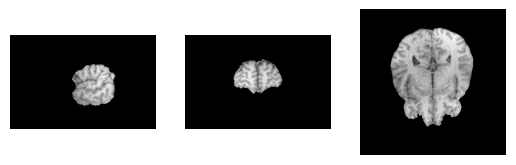

In [87]:
x_slice = image_data[59, :, :]
y_slice = image_data[:, 54, :]
z_slice = image_data[:, :, 64]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")
    axes[i].axis('off')

In [ ]:
def visualize_3d(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap='gray');#cmap='bone'
    plt.axis('off')
    return layer

interact(visualize_3d, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [ ]:
layer = 50

def visualize_3d_labels(layer):
    mask = nib.load('./brain_images/BraTS2021_00284/BraTS2021_00284_seg.nii.gz').get_fdata()
    plt.imshow(mask[:,:,layer], cmap="bone")
    plt.axis('off')
    plt.tight_layout()

interact(visualize_3d_labels, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [ ]:
layer = 50

def visualize_3d_labels(layer):
    mask = nib.load('./brain_images/BraTS2021_00284/BraTS2021_00284_seg.nii.gz').get_fdata()
    color_segmentation = np.zeros((240,240,3))
    gray_segmentation = mask[:,:,layer]
    color_segmentation[gray_segmentation == 1] = [255,0,0] # Red (necrotic tumor core)
    color_segmentation[gray_segmentation == 2] = [0,255,0] # Green (peritumoral edematous/invaded tissue)
    color_segmentation[gray_segmentation == 4] = [0,0,255] # Blue (enhancing tumor)
    plt.imshow(color_segmentation, cmap="gray") #cmap="bone"
    plt.axis('off')
    plt.tight_layout()

interact(visualize_3d_labels, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

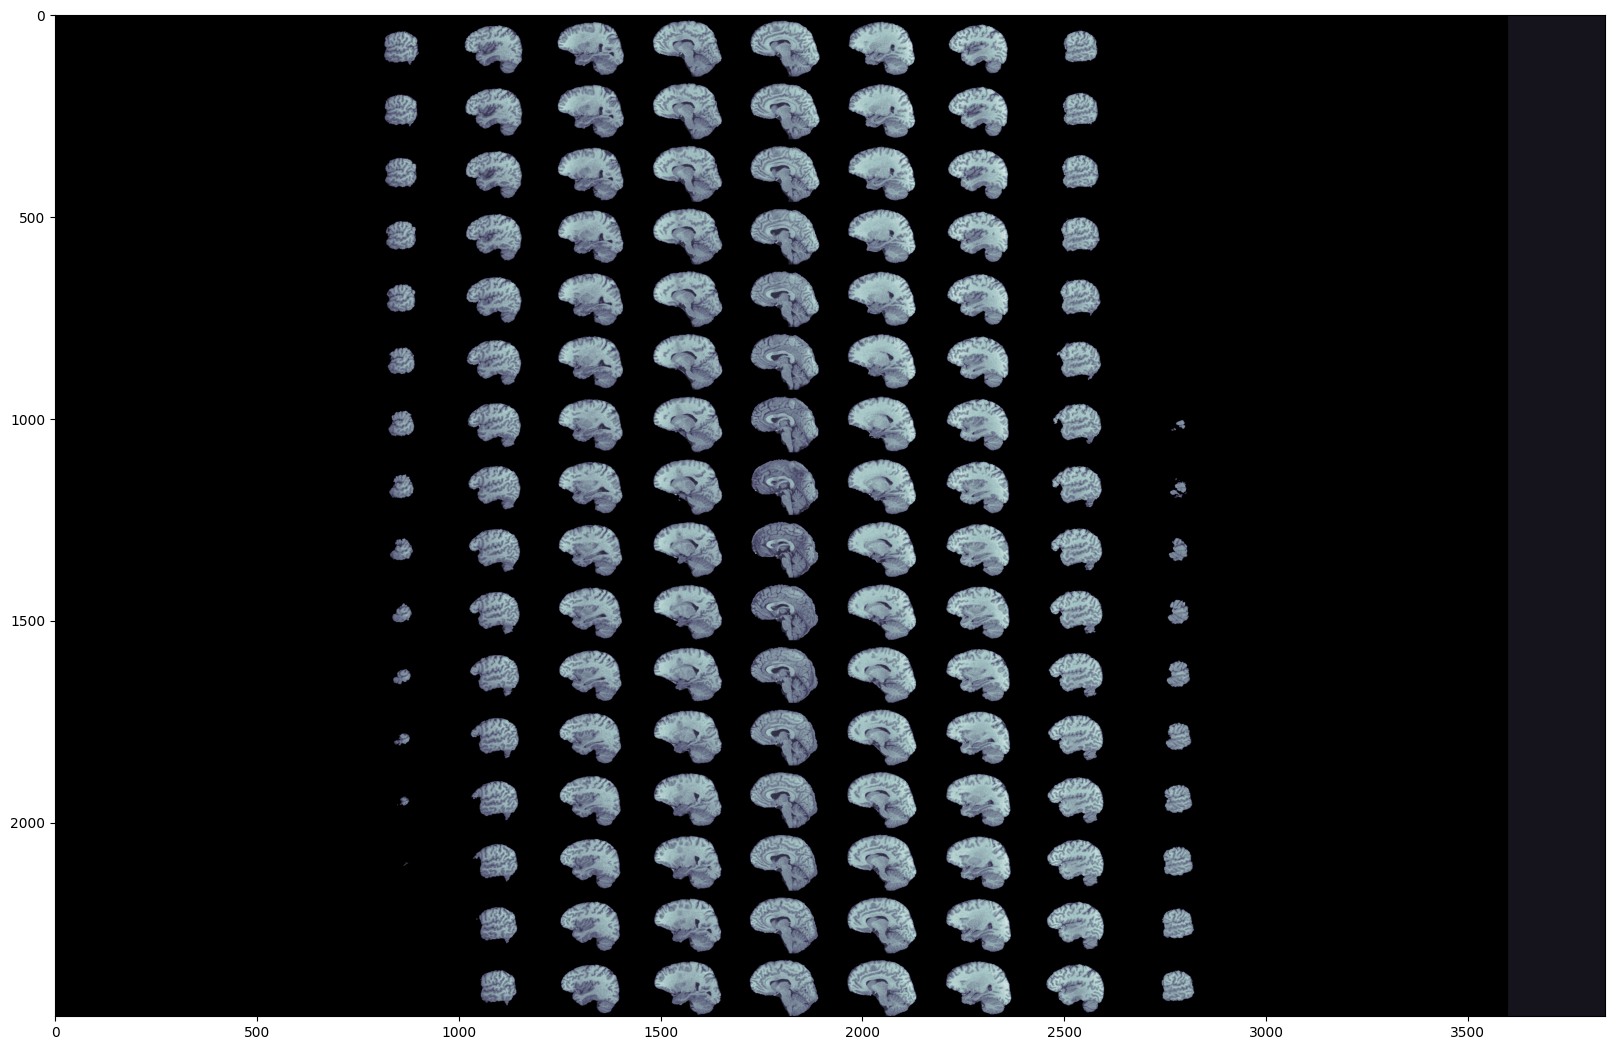

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (20,20))
ax1.imshow(rotate(montage(image_data[:,:,:]), 90, resize=True), cmap ='bone') #cmap ='gray'

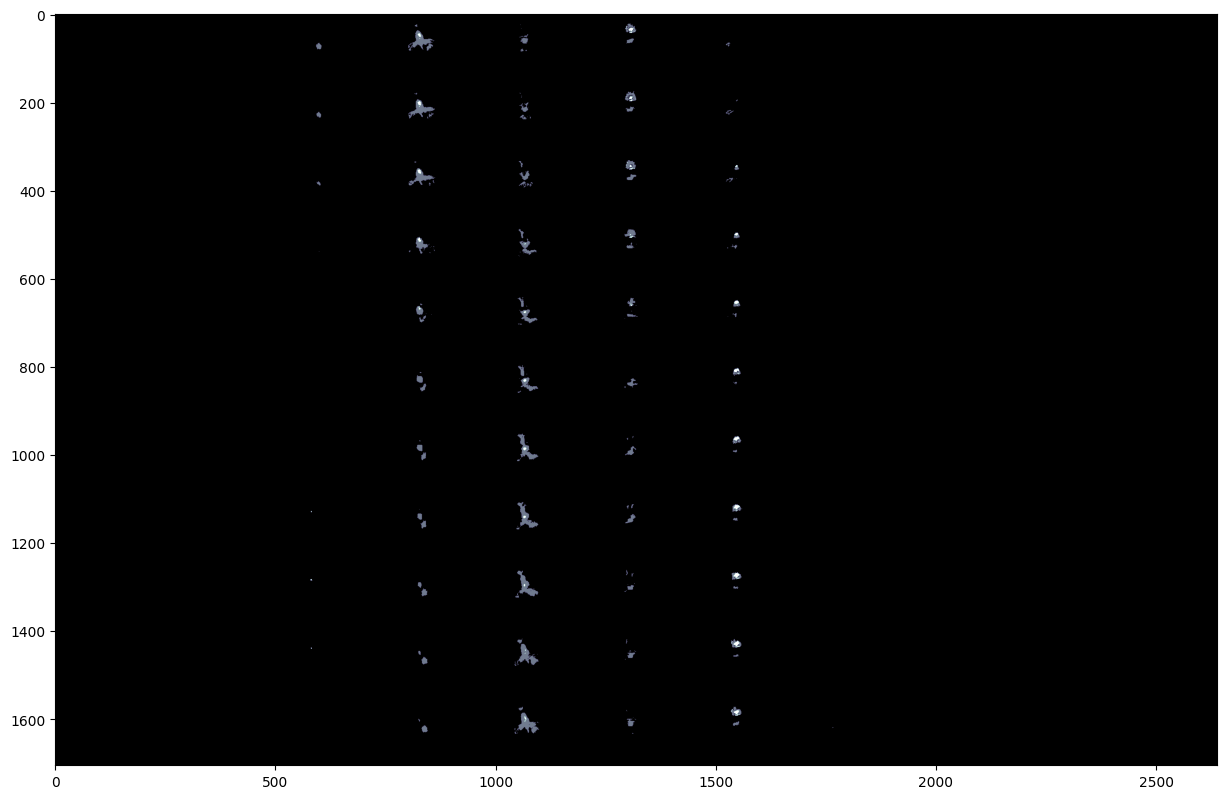

In [ ]:
mask = nib.load('./brain_images/BraTS2021_00284/BraTS2021_00284_seg.nii.gz').get_fdata()
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(mask[60:-60,:,:]), 90, resize=True), cmap ='bone')

/content/brain_images


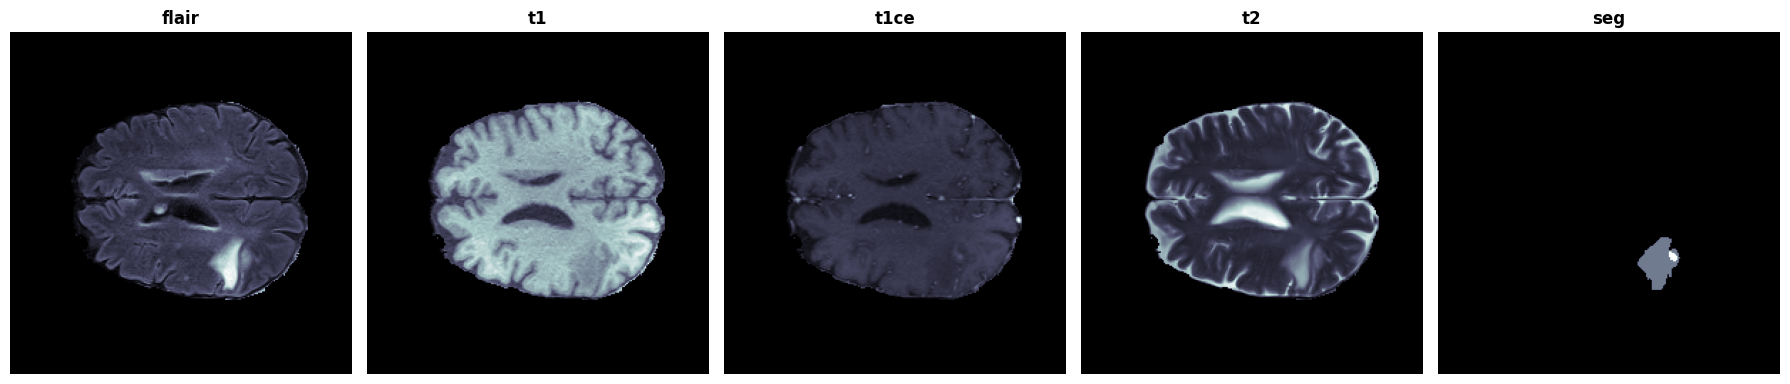

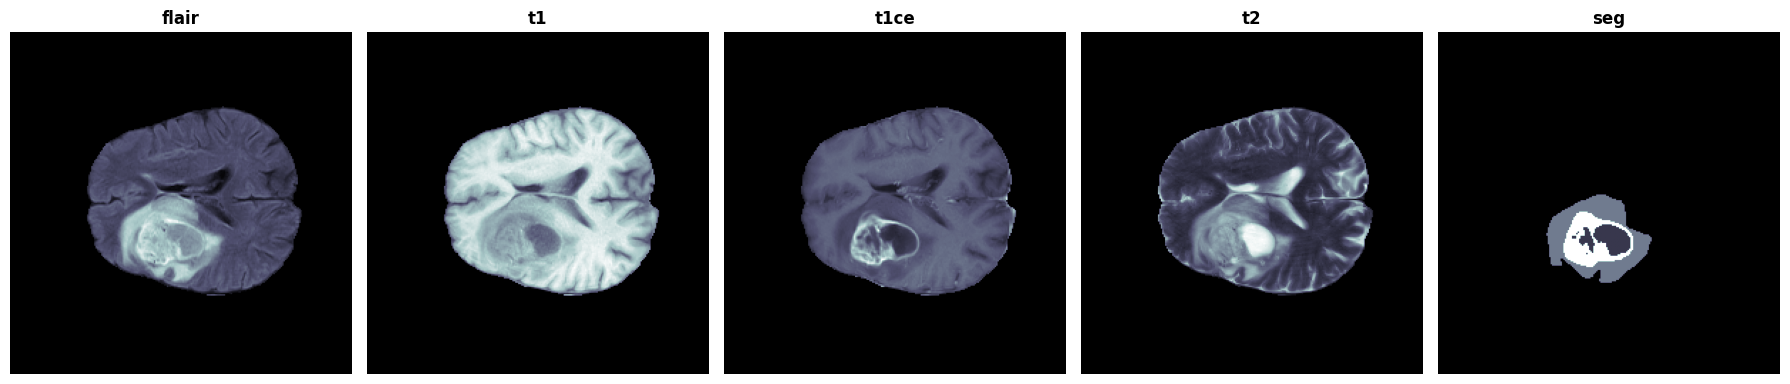

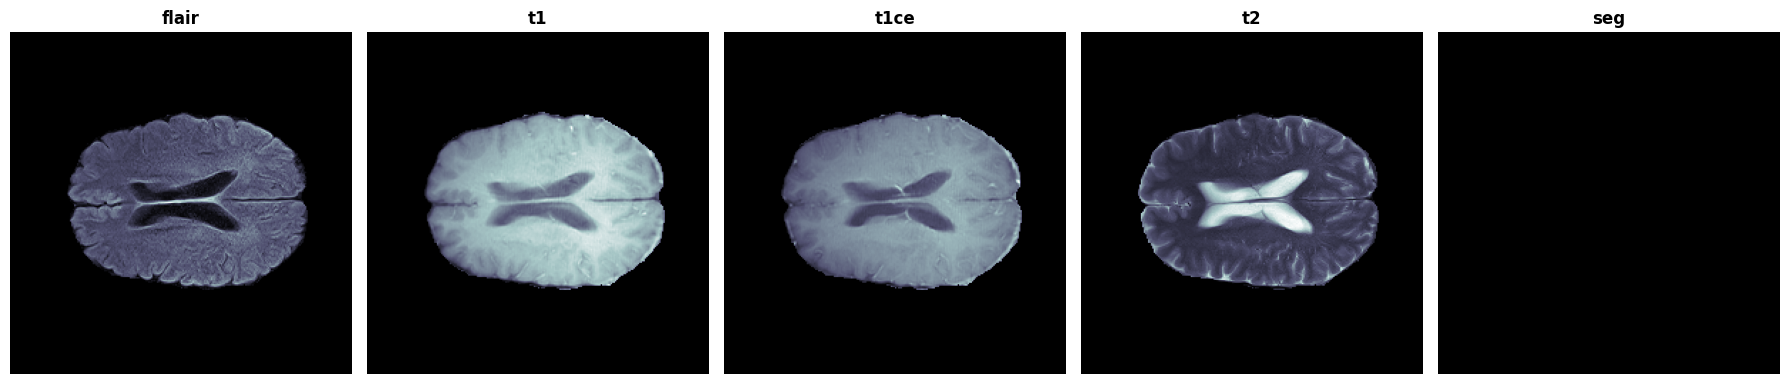

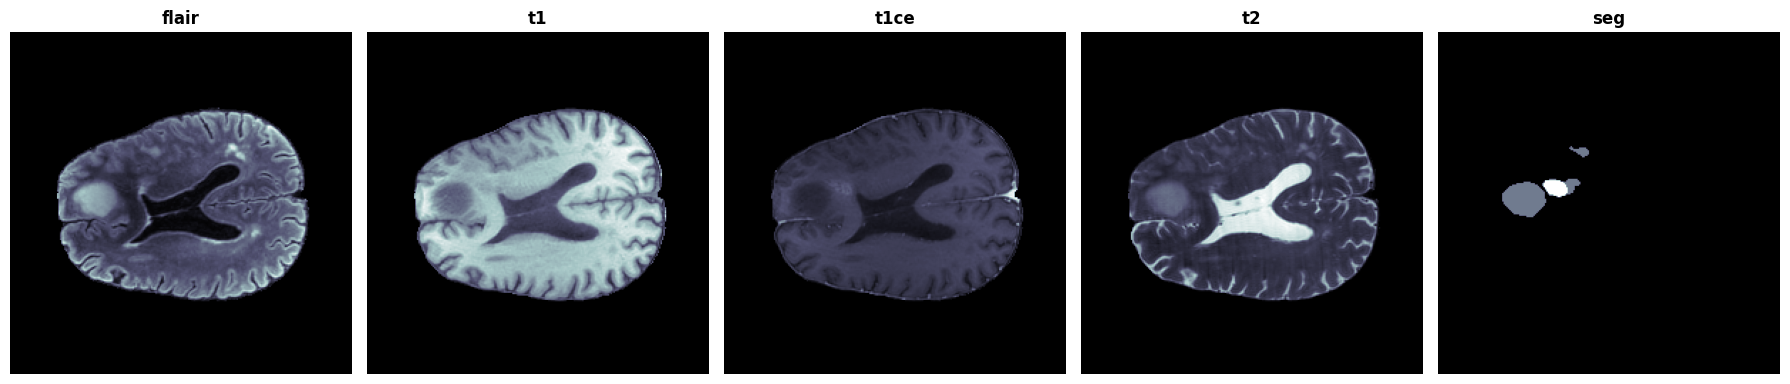

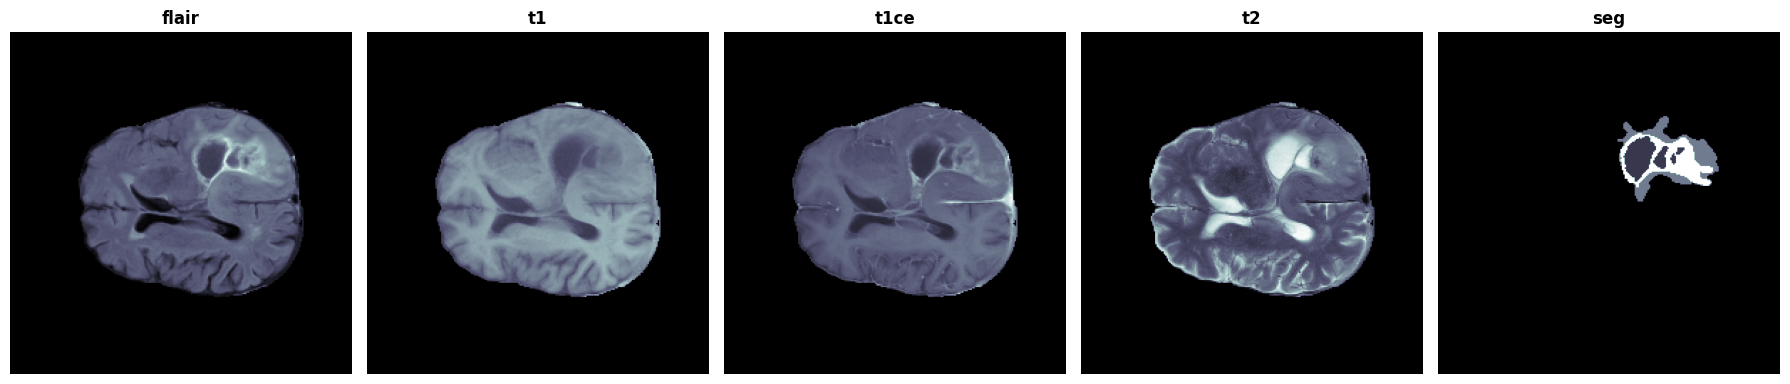

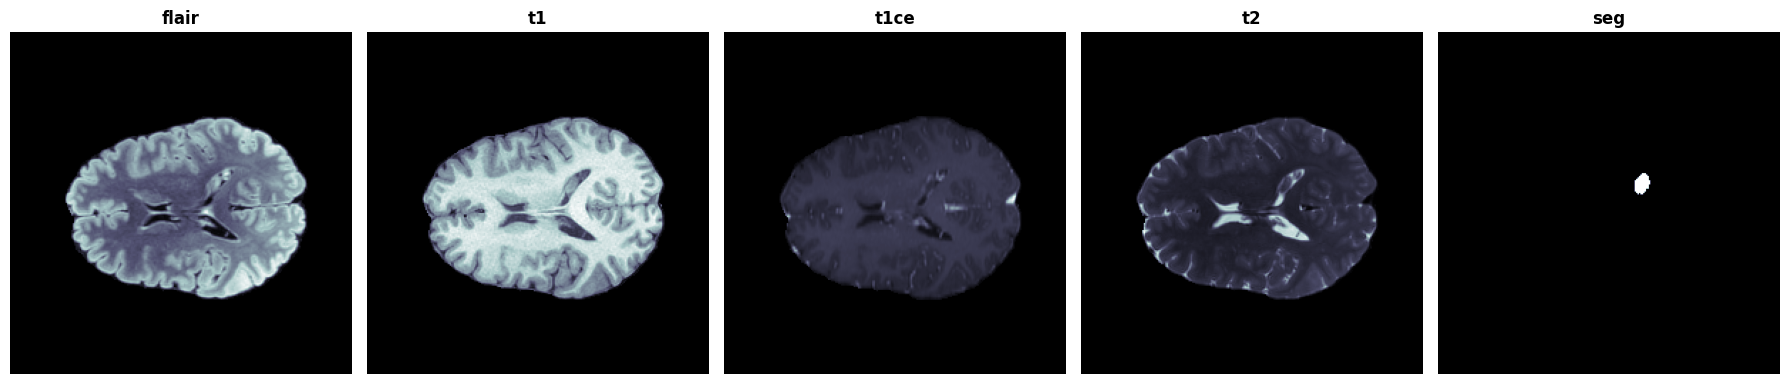

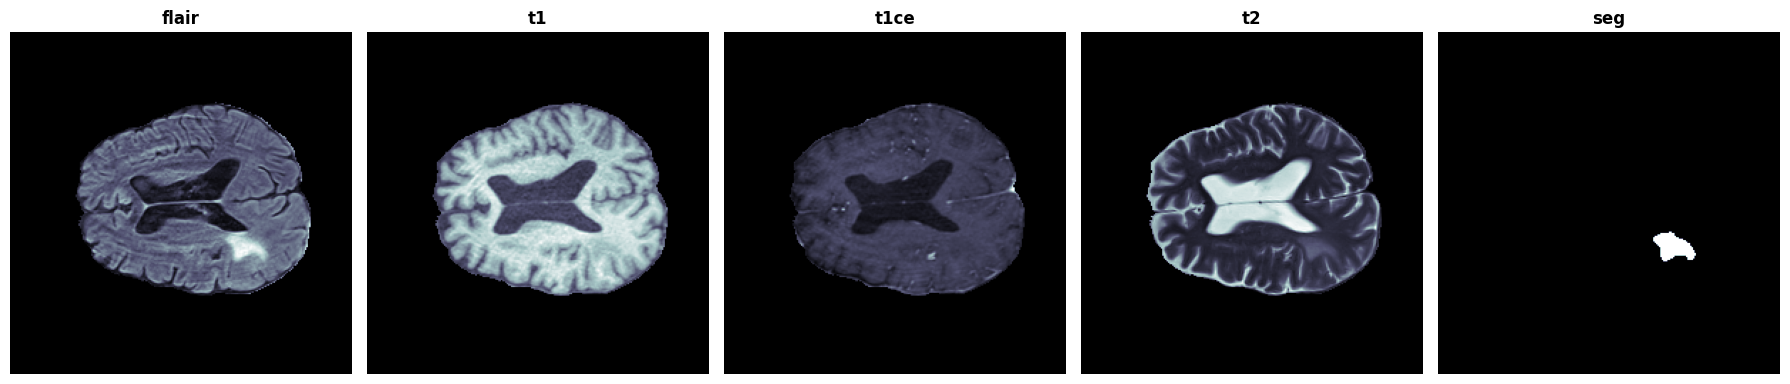

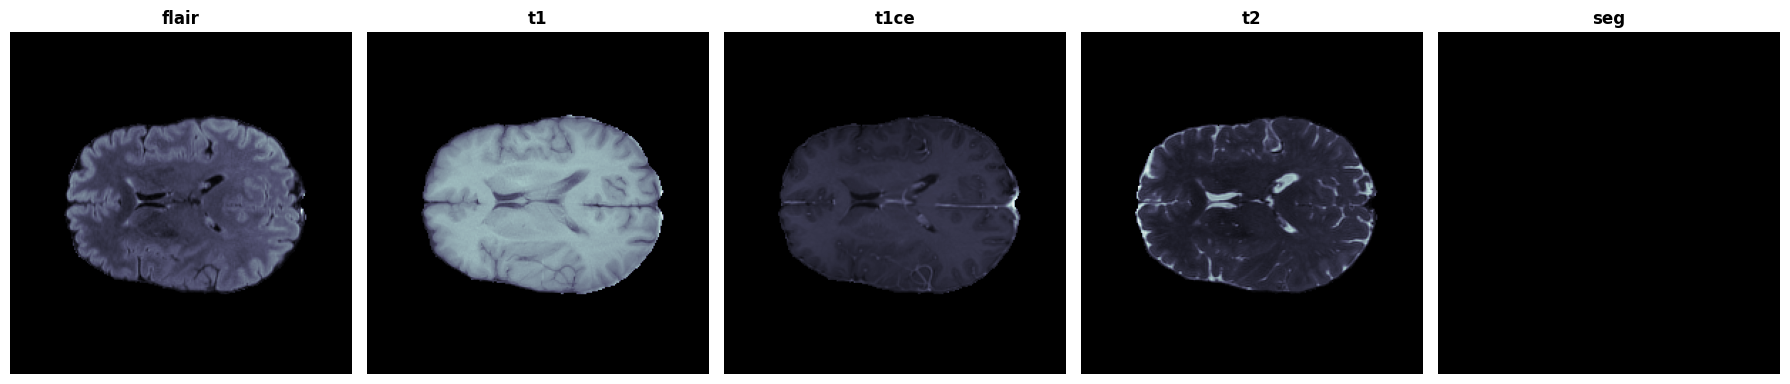

/content


In [ ]:
%cd /content/brain_images

img_ids = ["00376", "00789", "00441", "00703", "00807", "00523", "00241", "00778"]
SCAN_NUM = 83

for img_id in img_ids:
    plt.figure(figsize=(18, 5))

    for i, nii in enumerate([f'./BraTS2021_{img_id}/BraTS2021_{img_id}_{s_type}.nii.gz' for s_type in ["flair", "t1", "t1ce", "t2", "seg"]]):
        plt.subplot(1,5,i+1)
        image = nib.load(nii).get_fdata()
        plt.title(nii.rsplit("_", 1)[1].split(".", 1)[0], fontweight="bold")
        plt.axis(False)
        plt.imshow(image[:, :, SCAN_NUM], cmap="bone")
        
    plt.tight_layout()    
    plt.show()

%cd /content

##Data Split by using Holdout Method

In [9]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_test_ids = pathListIntoIds(train_and_val_directories); 

train_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) #test_size=0.25

##Data Generator

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 4, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)
        
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels)) # X : (n_samples, *dim, n_channels)
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))

        
        # data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1.nii.gz');
            t1 = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t2.nii.gz');
            t2 = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
             X[j+(VOLUME_SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,2] = cv2.resize(t1[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,3] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))             
             
             y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        X = X.reshape(1,128,128,128,4)
        y = y.reshape(1,128,128,128)

        # masks
        y[y==4] = 3;
        y = tf.one_hot(y, 4);

        return X/np.max(X), y

In [97]:
training_generator = DataGenerator(train_ids)
print(training_generator[0][0].shape)
valid_generator = DataGenerator(val_ids)

(1, 128, 128, 128, 4)


##3D GAN Model

In [ ]:
# Optimizers
generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

###Generator

In [94]:
def Gen():
################## Encoder ##################
  inputs = Input((128,128,128,4), name='input_image')
# Block 1
  x = Conv3D(64, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding=PAD)(inputs)
  x = ELU()(x)
  x = MaxPooling3D(pool_size=2, strides=2, name='MP1')(x)
  D1 = Dropout(DROP_RATE)(x)
# Block 2
  x = Conv3D(128, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding=PAD)(D1)
  x = GroupNormalization(groups=4, axis=4)(x)
  x = ELU()(x)
  x = MaxPooling3D(pool_size=2, strides=2, name='MP2')(x)
  D2 = Dropout(DROP_RATE)(x)
# Block 3
  x = Conv3D(192, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding=PAD)(D2)
  x = GroupNormalization(groups=4, axis=4)(x)
  x = ELU()(x)
  x = MaxPooling3D(pool_size=2, strides=2, name='MP3')(x)
  D3 = Dropout(DROP_RATE)(x)

# bottlenek
  # base
  x = Conv3D(256, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding=PAD)(D3)
  x = GroupNormalization(groups=4, axis=4)(x)
  x = ELU()(x)
  x = MaxPooling3D(pool_size=2, strides=2, name='MP4')(x)

  #1
  y = Conv3D(256, kernel_size=KERNEL_SIZE, strides=1, kernel_initializer=KERNEL_INIT, padding=PAD)(x)
  x = GroupNormalization(groups=4, axis=4)(y)
  x = ELU()(x)
  x = Concatenate()([x, y])

  #2
  y = Conv3D(256, kernel_size=KERNEL_SIZE, strides=1, kernel_initializer=KERNEL_INIT, padding=PAD)(x)
  x = GroupNormalization(groups=4, axis=4)(y)
  x = ELU()(x)
  x = Concatenate()([x, y])

  #3
  y = Conv3D(256, kernel_size=KERNEL_SIZE, strides=1, kernel_initializer=KERNEL_INIT, padding=PAD)(x)
  x = GroupNormalization(groups=4, axis=4)(y)
  x = ELU()(x)
  x = Concatenate()([x, y])

  #4
  y = Conv3D(256, kernel_size=KERNEL_SIZE, strides=1, kernel_initializer=KERNEL_INIT, padding=PAD)(x)
  x = GroupNormalization(groups=4, axis=4)(y)
  x = ELU()(x)
  x = Concatenate()([x, y])


################## Decoder ##################
  x = Conv3DTranspose(64, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding=PAD)(x)
  x = GroupNormalization(groups=4, axis=4)(x)
  x = ELU()(x)
  x = UpSampling3D(size=2)(x)
  x = Concatenate()([x, D3])
  x = Dropout(DROP_RATE)(x)

  x = Conv3DTranspose(64, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding=PAD)(x)
  x = GroupNormalization(groups=4, axis=4)(x)
  x = ELU()(x)
  x = UpSampling3D(size=2)(x)
  x = Concatenate()([x, D2])
  x = Dropout(DROP_RATE)(x)

  x = Conv3DTranspose(64, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding=PAD)(x)
  x = GroupNormalization(groups=4, axis=4)(x)
  x = ELU()(x)
  x = UpSampling3D(size=2)(x)
  x = Concatenate()([x, D1])
  x = Dropout(DROP_RATE)(x)


################## Output ##################
  out = Conv3DTranspose(4, kernel_size=KERNEL_SIZE, strides=2, kernel_initializer=KERNEL_INIT, padding=PAD, name='Gen_Output')(x)
  out = Activation('softmax')(out)
  return Model(inputs=inputs, outputs=out, name='Generator')

In [95]:
gen = Gen()
gen.summary(positions=[.33, .6, .7, 1.])

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape              Param #   Connected to                  
input_image (InputLayer)        [(None, 128, 128, 128, 4) 0                                       
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128, 64) 16448     input_image[0][0]             
__________________________________________________________________________________________________
elu_4 (ELU)                     (None, 128, 128, 128, 64) 0         conv3d[0][0]                  
__________________________________________________________________________________________________
MP1 (MaxPooling3D)              (None, 64, 64, 64, 64)    0         elu_4[0][0]                   
__________________________________________________________________________________________

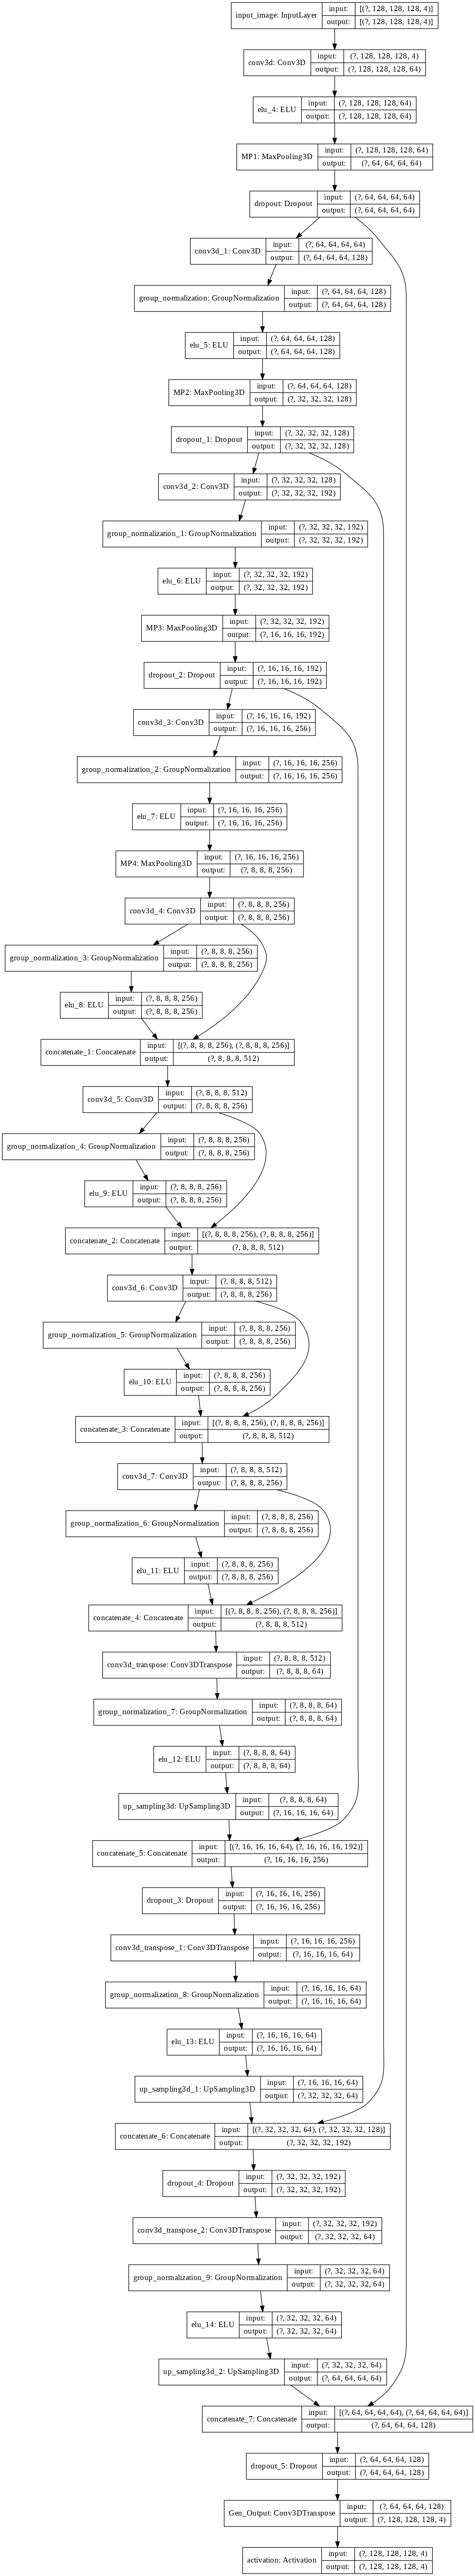

In [96]:
plot_model(gen, to_file='gen_model.png', show_shapes=True, dpi=100)

###Discriminator

In [91]:
def Disc():
  inputs = Input((128,128,128,4), name='input_image')
  targets = Input((128,128,128,4), name='target_image')
  x = Concatenate()([inputs, targets])

# Block 1
  x = Conv3D(64, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding='same', name='C1')(x)
  x = ELU()(x)
  x = MaxPooling3D(pool_size=2, strides=2, name='MP1')(x)
  D1 = Dropout(DROP_RATE, name='D1')(x)

# Block 2
  x = SpectralNormalization(Conv3D(128, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding='same', name='C2'))(D1)
  x = ELU()(x)
  x = MaxPooling3D(pool_size=2, strides=2, name='MP2')(x)
  D2 = Dropout(DROP_RATE, name='D2')(x)

# Block 3
  x = SpectralNormalization(Conv3D(256, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding='same', name='C3'))(D2)
  x = ELU()(x)
  x = MaxPooling3D(pool_size=2, strides=2, name='MP3')(x)
  D3 = Dropout(DROP_RATE, name='D3')(x)
  x = ZeroPadding3D()(D3)

# Block 4
  x = SpectralNormalization(Conv3D(512, kernel_size=KERNEL_SIZE, strides=1, dilation_rate=2, kernel_initializer=KERNEL_INIT, padding='same', name='C4'))(x)
  x = ELU()(x)
  x = MaxPooling3D(pool_size=2, strides=2, name='MP4')(x)   
  x = ZeroPadding3D()(x)

  out = Conv3D(1, kernel_size=KERNEL_SIZE, strides=1, padding='valid', kernel_initializer=KERNEL_INIT, name='disc_output')(x) 

  return Model(inputs=[targets, inputs], outputs=out, name='Discriminator')

In [92]:
disc = Disc()
disc.summary(positions=[.33, .6, .7, 1.])

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape              Param #   Connected to                  
input_image (InputLayer)        [(None, 128, 128, 128, 4) 0                                       
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 128, 128, 128, 4) 0                                       
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 128, 8)  0         input_image[0][0]             
                                                                    target_image[0][0]            
__________________________________________________________________________________________________
C1 (Conv3D)                     (None, 128, 128, 128, 64) 32832     concatenate[0][0] 

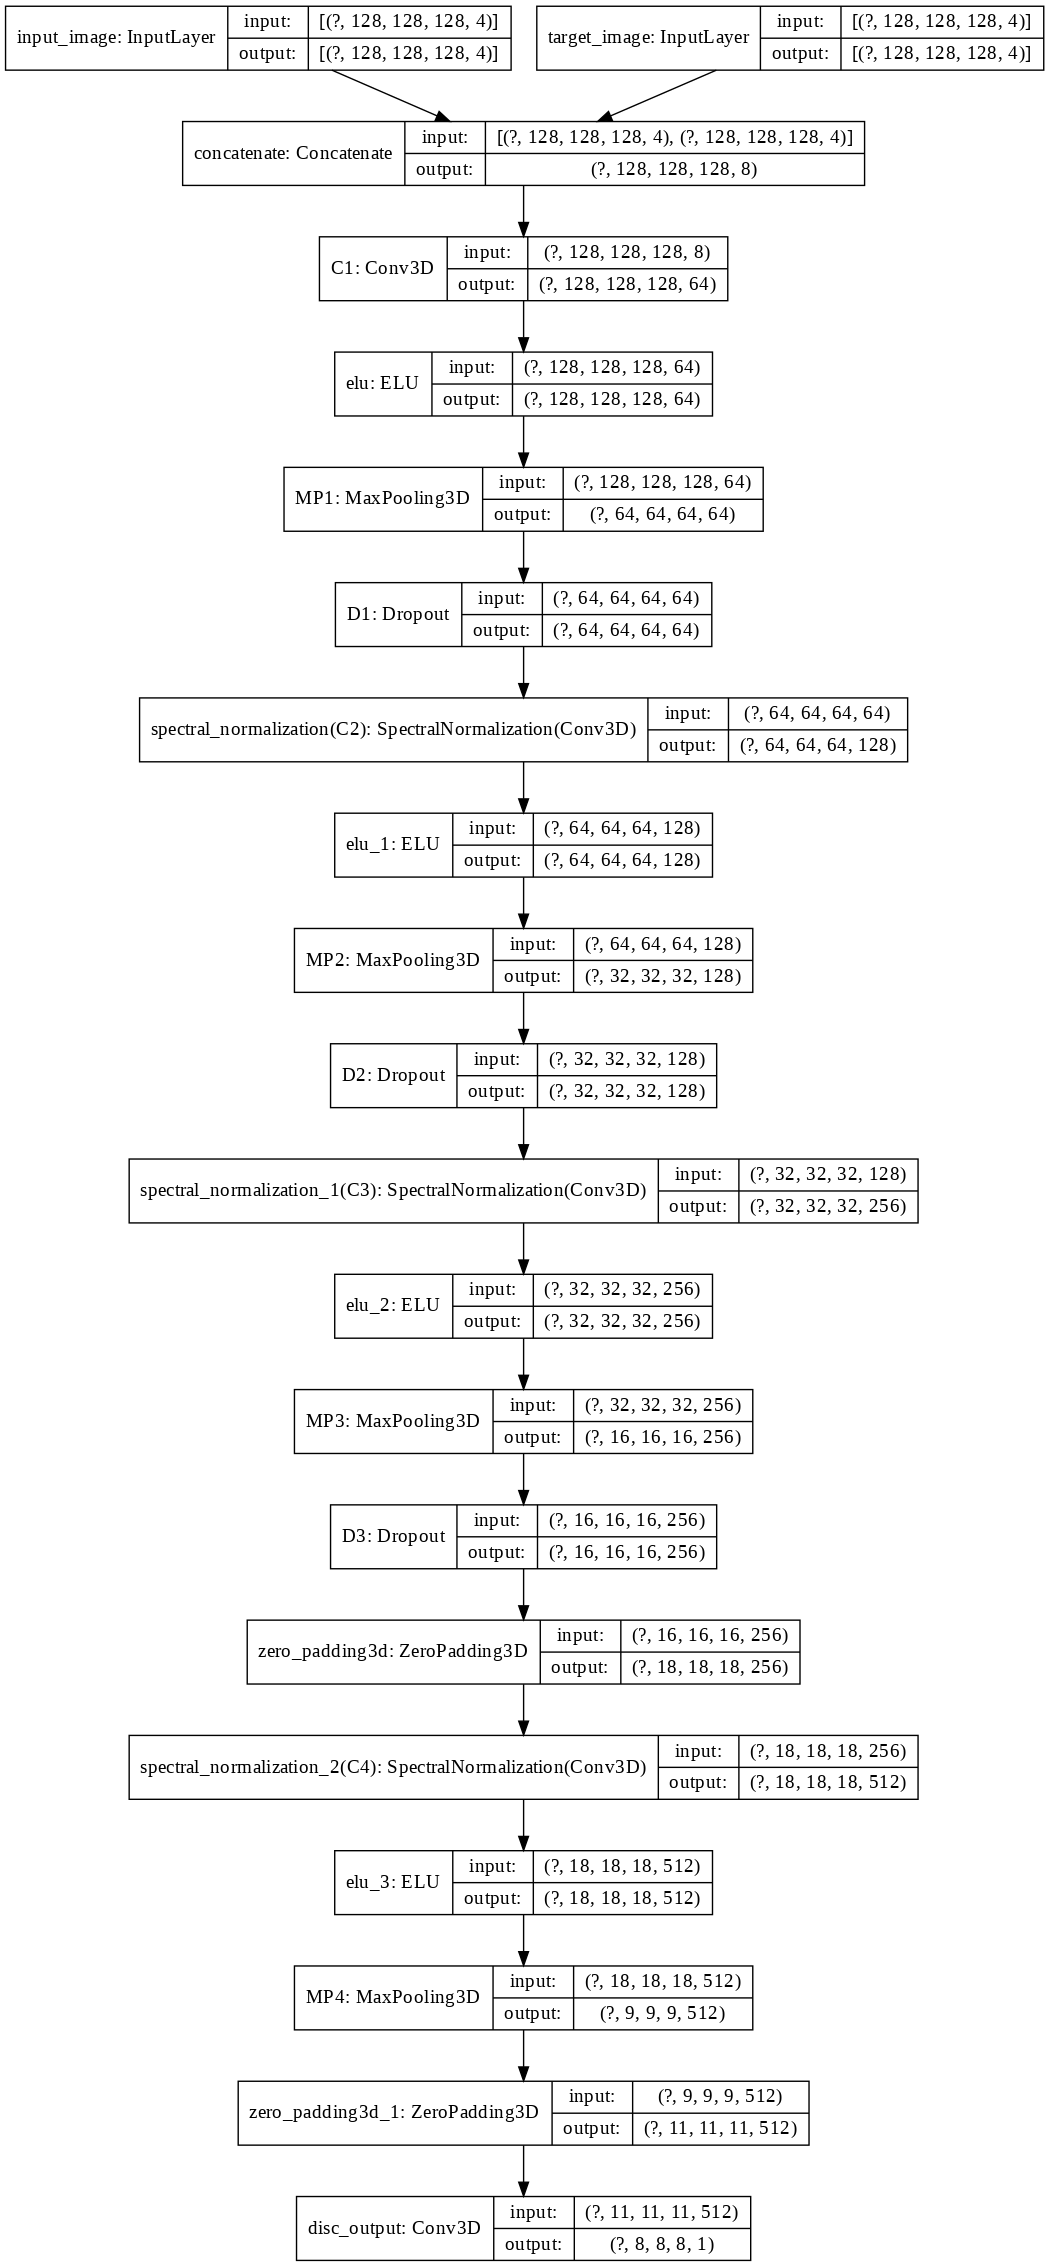

In [93]:
plot_model(disc, to_file='disc_model.png', show_shapes=True, dpi=100)

##Losses
ref: 
https://arxiv.org/pdf/1606.04797v1.pdf

https://arxiv.org/abs/2112.13054

In [90]:
class_weights = np.array([0.25659472, 45.465614, 16.543337, 49.11155], dtype='float32')

def diceLoss(y_true, y_pred, class_weights):
    '''Dice = (2*|X & Y|)/ (|X|+ |Y|) = 2*sum(|A*B|)/(sum(A^2)+sum(B^2))'''
    y_true = tf.convert_to_tensor(y_true, 'float32')
    y_pred = tf.convert_to_tensor(y_pred, y_true.dtype)

    num = tf.math.reduce_sum(tf.math.multiply(class_weights, tf.math.reduce_sum(tf.math.multiply(y_true, y_pred), axis=[0,1,2,3])))
    den = tf.math.reduce_sum(tf.math.multiply(class_weights, tf.math.reduce_sum(tf.math.add(y_true, y_pred), axis=[0,1,2,3])))+1e-5

    return 1-2*num/den

def discriminator_loss(disc_real_output, disc_fake_output):
    real_loss = tf.math.reduce_mean(tf.math.pow(tf.ones_like(disc_real_output) - disc_real_output, 2))
    fake_loss = tf.math.reduce_mean(tf.math.pow(tf.zeros_like(disc_fake_output) - disc_fake_output, 2))

    disc_loss = 0.5*(real_loss + fake_loss)

    return disc_loss


def generator_loss(target, gen_output, disc_fake_output, class_weights, alpha):
    
    # dice loss
    dice_loss = diceLoss(target, gen_output, class_weights)
    
    # disc loss
    disc_loss = tf.math.reduce_mean(tf.math.pow(tf.ones_like(disc_fake_output) - disc_fake_output, 2))
       
    # total loss
    gen_loss = alpha*dice_loss + disc_loss

    return gen_loss, dice_loss, disc_loss

##Training Function

In [99]:
@tf.function
def train_step(image, target, alpha):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_output = gen(image, training=True)

        disc_real_output = disc([image, target], training=True)
        disc_fake_output = disc([image, gen_output], training=True)
        disc_loss = discriminator_loss(disc_real_output, disc_fake_output)
        
        gen_loss, dice_loss, disc_loss_gen = generator_loss(target, gen_output, disc_fake_output, class_weights, alpha)
    # Calculate the gradients
    generator_gradients = gen_tape.gradient(gen_loss, gen.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
    # Apply the gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
        
    return gen_loss, dice_loss, disc_loss_gen
        
@tf.function
def test_step(image, target, alpha):
    gen_output = gen(image, training=False)

    disc_real_output = disc([image, target], training=False)
    disc_fake_output = disc([image, gen_output], training=False)
    disc_loss = discriminator_loss(disc_real_output, disc_fake_output)

    gen_loss, dice_loss, disc_loss_gen = generator_loss(target, gen_output, disc_fake_output, class_weights, alpha)
        
    return gen_loss, dice_loss, disc_loss_gen

def fit(train_gen, valid_gen, alpha, epochs):
    # path = './RESULTS' #saving in content
    path = '/content/drive/MyDrive/RESULTS' ##saving in drive
    if os.path.exists(path)==False:
        os.mkdir(path)
        
    Nt = len(train_gen)
    history = {'train': [], 'valid': []}
    prev_loss = np.inf
    
    epoch_v2v_loss = tf.keras.metrics.Mean()
    epoch_dice_loss = tf.keras.metrics.Mean()
    epoch_disc_loss = tf.keras.metrics.Mean()
    epoch_v2v_loss_val = tf.keras.metrics.Mean()
    epoch_dice_loss_val = tf.keras.metrics.Mean()
    epoch_disc_loss_val = tf.keras.metrics.Mean()
    
    for e in range(epochs):
        print('Epoch {}/{}'.format(e+1,epochs))
        b = 0
        for Xb, yb in train_gen:
            b += 1
            losses = train_step(Xb, yb, alpha)
            epoch_v2v_loss.update_state(losses[0])
            epoch_dice_loss.update_state(losses[1])
            epoch_disc_loss.update_state(losses[2])
            # epoch_m_iou.update_state()
            
            stdout.write('\rBatch: {}/{} - loss: {:.4f} - dice_loss: {:.4f} - disc_loss: {:.4f}'
                         .format(b, Nt, epoch_v2v_loss.result(), epoch_dice_loss.result(), epoch_disc_loss.result()))
            stdout.flush()
        history['train'].append([epoch_v2v_loss.result(), epoch_dice_loss.result(), epoch_disc_loss.result()])
        
        for Xb, yb in valid_gen:
            losses_val = test_step(Xb, yb, alpha)
            epoch_v2v_loss_val.update_state(losses_val[0])
            epoch_dice_loss_val.update_state(losses_val[1])
            epoch_disc_loss_val.update_state(losses_val[2])
            
        stdout.write('\n               loss_val: {:.4f} - dice_loss_val: {:.4f} - disc_loss_val: {:.4f}'
                     .format(epoch_v2v_loss_val.result(), epoch_dice_loss_val.result(), epoch_disc_loss_val.result()))
        stdout.flush()
        history['valid'].append([epoch_v2v_loss_val.result(), epoch_dice_loss_val.result(), epoch_disc_loss_val.result()])
        
        # save pred image at epoch e 
        y_pred = gen.predict(Xb)
        y_true = np.argmax(yb, axis=-1)
        y_pred = np.argmax(y_pred, axis=-1)

        canvas = np.zeros((128, 128*3))
        idx = np.random.randint(len(Xb))
        
        x = Xb[idx,:,:,64,2] 
        canvas[0:128, 0:128] = (x - np.min(x))/(np.max(x)-np.min(x)+1e-6)
        canvas[0:128, 128:2*128] = y_true[idx,:,:,64]/3
        canvas[0:128, 2*128:3*128] = y_pred[idx,:,:,64]/3
        
        fname = (path + '/pred@epoch_{:03d}.png').format(e+1)
        mpim.imsave(fname, canvas, cmap='gray')
        
        # save models
        print(' ')
        if epoch_v2v_loss_val.result() < prev_loss:    
            gen.save_weights(path + '/Generator.h5') 
            disc.save_weights(path + '/Discriminator.h5')
            print("Validation loss decresaed from {:.4f} to {:.4f}. Models' weights are now saved.".format(prev_loss, epoch_v2v_loss_val.result()))
            prev_loss = epoch_v2v_loss_val.result()
        else:
            print("Validation loss did not decrease from {:.4f}.".format(prev_loss))
        print(' ')
        
        # resets losses states
        epoch_v2v_loss.reset_states()
        epoch_dice_loss.reset_states()
        epoch_disc_loss.reset_states()
        epoch_v2v_loss_val.reset_states()
        epoch_dice_loss_val.reset_states()
        epoch_disc_loss_val.reset_states()
        
        del Xb, yb, canvas, y_pred, y_true, idx
        
    return history

##Training and Testing

In [ ]:
start = time.time()
alpha = 5
n_epochs = 1
h = fit(training_generator, valid_generator, alpha, n_epochs)
end = time.time()
total_time = end - start
print(total_time)

Epoch 1/1
Batch: 850/850 - loss: 3.6196 - dice_loss: 0.5219 - disc_loss: 1.0102
               loss_val: 2.8606 - dice_loss_val: 0.4048 - disc_loss_val: 0.8365 
Validation loss decresaed from inf to 2.8606. Models' weights are now saved.
 
